In [150]:
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import convolve2d
from math import comb
import concurrent.futures
import cv2


In [4]:

def get_gray_img_mat(img_path):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    return img_array


def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Function '{func.__name__}' took {duration:.6f} seconds to run.")
        return result

    return wrapper


def expand_image(img, expanded_size, kernel_size=5, ratio=2):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / (weights / 4)
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0] * ratio:ratio, :img.shape[1] * ratio:ratio] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


# create a function that returns the gaussian kernel for a given size and the total sum of the kernel
# for example ofr size=5 return kernel = np.array([[1, 4, 6, 4, 1],
# [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) and weight = 256
def get_gaussian_kernel(size):
    # Calculate the kernel
    n = math.floor(size)
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = comb(n - 1, i) * comb(n - 1, j)

    # Normalize the kernel to make the sum an integer
    kernel_sum = np.sum(kernel)
    kernel_factor = int(np.ceil(kernel_sum))
    kernel = (kernel * kernel_factor / kernel_sum).astype(int)

    return kernel, kernel_factor


def reduce_image(img, reduced_img_size, kernel_size=5, should_blur=True):
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / weights
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))

    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]

    return reduced_img


def get_reduced_size(img, factor=2):
    return (img.shape[0] // factor, img.shape[1] // factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1]))) - 1


# @measure_time
def create_pyramid(img, kernel_size=5):
    pyramid = []
    pyramid.append({'G': img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size, kernel_size)
        expanded_image_size = pyramid[i - 1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size, kernel_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})

    for i in range(len(pyramid) - 1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i + 1]['Expanded_G']
    pyramid[-1]['L'] = pyramid[-1]['G']
    return pyramid


def plot_gaussian_pyramid(pyramid, levels=None):
    if levels is None:
        levels = range(len(pyramid))
    plt.subplots(1, len(levels), figsize=(20, 20))
    for index, level in enumerate(levels):
        plt.subplot(1, len(levels), index + 1)
        plt.imshow(pyramid[level]['G'], cmap="gray")
        plt.title(f"Level {level}")
    plt.show()


def plot_expanded_gaussian_pyramid(pyramid):
    plt.subplots(1, (len(pyramid) - 1), figsize=(20, 20))
    for i in range(len(pyramid) - 1):
        plt.subplot(1, len(pyramid) - 1, i + 1)
        plt.imshow(pyramid[i + 1]['Expanded_G'], cmap="gray")
        plt.title(f"Level {i + 1} Expanded")
    plt.show()


def plot_laplacian_pyramid(pyramid, levels=None):
    if levels is None:
        levels = range(len(pyramid))
    plt.subplots(1, len(levels), figsize=(20, 20))
    for index, level in enumerate(levels):
        plt.subplot(1, len(levels), index + 1)
        plt.imshow(pyramid[level]['L'], cmap="gray")
        plt.title(f"Level {level}")
    plt.show()


def get_mask_pyramid(mask):
    mask = np.ceil(mask / 255)
    mask_pyramid = []
    mask_pyramid.append({'G': mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid


def reconstruct_image(pyramid):
    reconstructed_img = pyramid[-1]['L']
    for i in range(len(pyramid) - 2, -1, -1):
        expanded_img = expand_image(reconstructed_img, pyramid[i]['L'].shape)
        reconstructed_img = expanded_img + pyramid[i]['L']
    return reconstructed_img


def blend_pyramids(pyramid1, pyramid2, mask_pyramid, max_level=100):
    blended_pyramid = []
    i = 0
    max_level = min(max_level, len(pyramid1))
    for i in range(max_level - 1):
        blended_pyramid.append(
            {'L': pyramid1[i]['L'] * mask_pyramid[i]['G'] + (1 - mask_pyramid[i]['G']) * pyramid2[i]['L']})
    # the last level is blended differently
    blended_pyramid.append(
        {'L': pyramid1[i + 1]['G'] * mask_pyramid[i + 1]['G'] + (1 - mask_pyramid[i + 1]['G']) * pyramid2[i + 1]['G']})
    return blended_pyramid


def rgb_to_yiq(img):
    # Conversion matrix from RGB to YIQ
    conversion_matrix = np.array([[0.299, 0.587, 0.114],
                                  [0.595716, -0.274453, -0.321263],
                                  [0.211456, -0.522591, 0.311135]])
    # Apply the conversion matrix
    yiq_image = np.dot(img.astype(float), conversion_matrix.T)

    # Clip values to [0, 255] range and convert to integers
    yiq_image = np.clip(yiq_image, 0, 255).astype(int)

    return yiq_image


def yiq_to_rgb(img_array):
    # Conversion matrix from YIQ to RGB
    conversion_matrix = np.array([[1, 0.9663, 0.6210],
                                  [1, -0.2721, -0.6474],
                                  [1, -1.1070, 1.7046]])

    # Apply the conversion matrix
    rgb_image = np.dot(img_array.astype(float), conversion_matrix.T)

    # Clip values to [0, 255] range and convert to integers
    rgb_image = np.clip(rgb_image, 0, 255).astype(int)

    return rgb_image


# the method opens an image based on its path and return 3 matrices in Y, I and Q color spaces
def open_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    return rgb_to_yiq(img_array)

    
def blend_images(img1, img2, mask, max_level, kernel_size=5):
    with (concurrent.futures.ThreadPoolExecutor() as executor):
        img1_pyramid_a, img1_pyramid_b, img1_pyramid_c = create_pyramid(img1[:, :, 0], kernel_size), create_pyramid(
            img1[:, :, 1], kernel_size), create_pyramid(img1[:, :, 2], kernel_size)
        img2_pyramid_a, img2_pyramid_b, img2_pyramid_c = create_pyramid(img2[:, :, 0], kernel_size), create_pyramid(
            img2[:, :, 1], kernel_size), create_pyramid(img2[:, :, 2], kernel_size)
        mask_pyramid = get_mask_pyramid(mask)
        blended_pyramid_a = blend_pyramids(img1_pyramid_a, img2_pyramid_a, mask_pyramid, max_level)
        blended_pyramid_b = blend_pyramids(img1_pyramid_b, img2_pyramid_b, mask_pyramid, max_level)
        blended_pyramid_c = blend_pyramids(img1_pyramid_c, img2_pyramid_c, mask_pyramid, max_level)
    return yiq_to_rgb(np.dstack((reconstruct_image(blended_pyramid_a), reconstruct_image(blended_pyramid_b),
                                 reconstruct_image(blended_pyramid_c))))


def q1(img_1_path, img_2_path, mask_path, kernel_size=5, max_level=100):
    img1 = open_image(img_1_path)
    img2 = open_image(img_2_path)
    mask = get_gray_img_mat(mask_path)
    blended_img = blend_images(img1, img2, mask, max_level, kernel_size)
    return blended_img


def blend_pyramids_based_on_level(pyramid1, pyramid2, max_level_1):
    blended_pyramid = []
    for i in range(max_level_1):
        blended_pyramid.append({'L': pyramid1[i]['L']})
    for i in range(max_level_1, len(pyramid1)):
        blended_pyramid.append({'L': pyramid2[i]['L']})
    return blended_pyramid


def q2(img_1_path, img_2_path, kernel_size=5, level=2):
    img_1 = get_gray_img_mat(img_1_path)
    img_2 = get_gray_img_mat(img_2_path)
    pyramid1 = create_pyramid(img_1, kernel_size)
    pyramid2 = create_pyramid(img_2, kernel_size)
    blended_pyramid = blend_pyramids_based_on_level(pyramid1, pyramid2, level)
    reconstructed_img = reconstruct_image(blended_pyramid)
    return reconstructed_img



In [158]:
def cv2_open_image(img_path):
    img = cv2.imread(img_path)
    return img

def cv2_get_gray_img_mat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [159]:
img_high_res = cv2_open_image('./assets/desert_high_res.png')
img_low_res = cv2_open_image('./assets/desert_low_res.jpg')

In [160]:
img_high_res_gray = cv2_get_gray_img_mat(img_high_res)
img_low_res_gray = cv2_get_gray_img_mat(img_low_res)

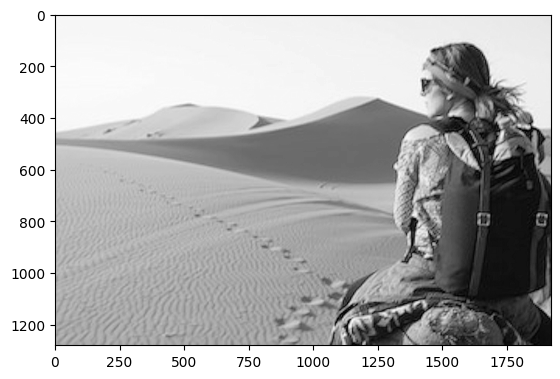

In [281]:
plt.imshow(img_low_res_gray, cmap='gray')


0 0
1 594
2 81
3 34
4 40


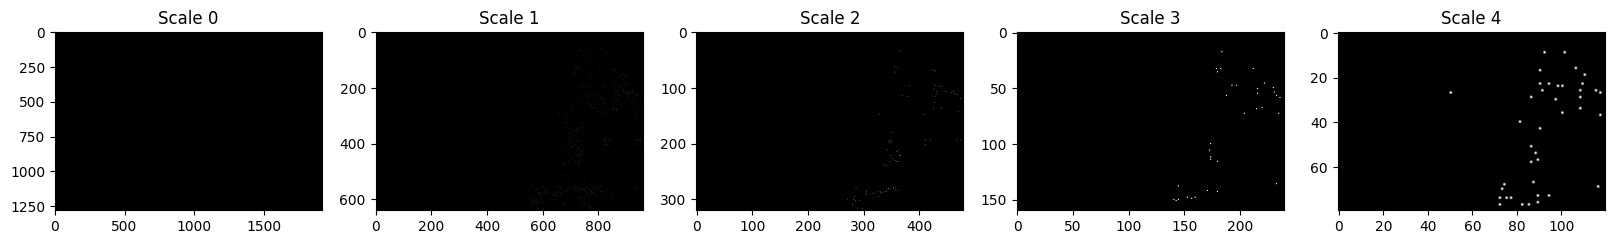

In [199]:
from copy import deepcopy
import cv2
from scipy.ndimage import maximum_filter

# implementing Harris corner detection
def harris_corner_detection(gray_img, harris_window_size, k, threshold, gaussian_window_size, suppression_window_size):

    img_gaussian = cv2.GaussianBlur(gray_img,(gaussian_window_size,gaussian_window_size),0)    
    Ix = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy
            
    harris_window = np.ones((harris_window_size, harris_window_size))
    Sx2 = convolve2d(Ix2, harris_window, mode='same')
    Sy2 = convolve2d(Iy2, harris_window, mode='same')
    Sxy = convolve2d(Ixy, harris_window, mode='same')

    det = Sx2 * Sy2 - (Sxy ** 2)
    trace = Sx2 + Sy2

    R = det - k * (trace ** 2)
    
    cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX)
    
    corners = deepcopy(R)
    corners[R < threshold] = 0
    # print('before', np.sum(corners[np.where(corners > 0)]))
    corners = non_maximum_suppression(corners, 3)
    # print('after', np.sum(corners[np.where(corners > 0)]))
    corners[corners > threshold] = 1
    return corners

# Suppress non-maximum responses
def non_maximum_suppression(corners, suppression_window_size):
    # Apply maximum filter for non-maximum suppression
    suppressed_corners = corners * (corners == maximum_filter(corners, footprint=np.ones((suppression_window_size, suppression_window_size))))
    return suppressed_corners


# create multiscale Harris corner detector
def multiscale_harris_corner_detector(pyramid, scales, harris_window_size, k, threshold, gaussian_window_size, suppression_window_size):
    # Initialize corners tensor
    corners_arr = np.zeros((scales,), dtype=np.ndarray)
    # Iterate over the scales in the pyramid 
    for scale in range(scales):
        # Perform the Harris corner detection
        corners = harris_corner_detection(pyramid[scale]['G'], harris_window_size, k, threshold, gaussian_window_size, suppression_window_size)     
        
        # if most of the pixels detected as corners, return an empty matrix for the current scale
        if np.sum(corners > threshold) >= 0.1 * corners.size:
            corners = np.zeros_like(corners)
        
        # Add the corners to the corners tensor
        corners_arr[scale] = corners
    return corners_arr




threshold = 0.3
harris_window_size = 5
k = 0.04
gaussian_window_size = 3
suppression_window_size = 5

scales = 5

low_pyramid = create_pyramid(img_low_res_gray, gaussian_window_size)
high_pyramid = create_pyramid(img_high_res_gray, gaussian_window_size)
corners_arr_low = multiscale_harris_corner_detector(low_pyramid, scales, harris_window_size, k, threshold, gaussian_window_size, suppression_window_size)
corners_arr_high = multiscale_harris_corner_detector(high_pyramid, scales, harris_window_size, k, threshold, gaussian_window_size, suppression_window_size)

# iterate over the scales and plot the corners
plt.subplots(1, scales, figsize=(20, 20))
for i in range(scales):
    print(i, np.sum(corners_arr_low[i] == 1))
    plt.subplot(1, scales, i + 1)
    plt.imshow(corners_arr_low[i], cmap='gray')
    plt.title(f"Scale {i}")
    

0 320
1 94
2 22
3 0
4 11


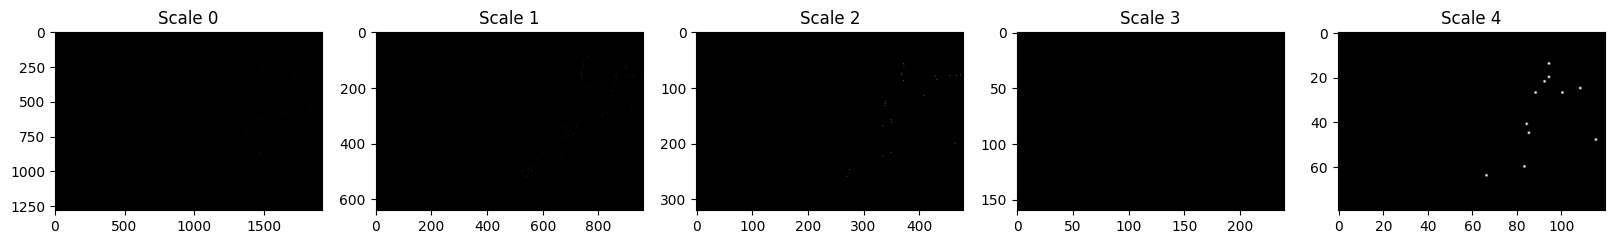

In [200]:
# iterate over the scales and plot the corners
plt.subplots(1, scales, figsize=(20, 20))
for i in range(scales):
    print(i, np.sum(corners_arr_high[i] == 1))
    plt.subplot(1, scales, i + 1)
    plt.imshow(corners_arr_high[i], cmap='gray')
    plt.title(f"Scale {i}")

In [336]:
def backward_warping_window(x, y, img, window_size, theta):
    output_img = np.zeros((window_size, window_size))
    for i in range(window_size):
        for j in range(window_size):
            # Translate the coordinates to be relative to the center of the window
            x_rel, y_rel = i - window_size // 2, j - window_size // 2
            # Apply rotation transformation
            x_rot = int(x_rel * math.cos(theta) - y_rel * math.sin(theta)) + x
            y_rot = int(x_rel * math.sin(theta) + y_rel * math.cos(theta)) + y
            
            # Ensure the rotated coordinates are within the bounds of the original image
            if 0 <= x_rot < img.shape[1] and 0 <= y_rot < img.shape[0]:
                # Perform bilinear interpolation
                x0, y0 = int(x_rot), int(y_rot)
                x1, y1 = x0 + 1, y0 + 1
                dx, dy = x_rot - x0, y_rot - y0
                try:
                    output_img[j, i] = (1 - dx) * (1 - dy) * img[y0, x0] + dx * (1 - dy) * img[y0, x1] + (1 - dx) * dy * img[y1, x0] + dx * dy * img[y1, x1]
                except IndexError:
                    pass
                
    return output_img

# normalize the corners windows (I = I - mean(I)/ std(I))
def normalize_window(window):
    return (window - np.mean(window)) / np.std(window)


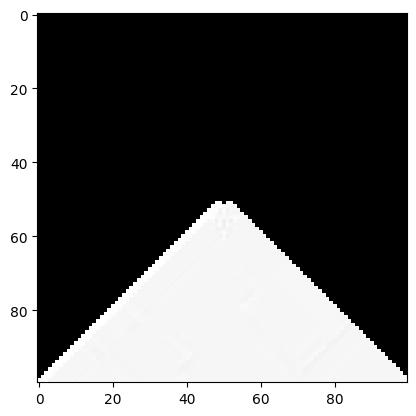

In [355]:
window_size = 100
theta = np.pi * -0.25
warped_window = backward_warping_window(0, 0, img_low_res_gray, window_size, theta)
plt.imshow(warped_window, cmap='gray')

In [380]:
descriptors = []
# create MOPS descriptors for the detected corners
for scale in range(scales):
    # Get the corners for the current scale
    corners = corners_arr_low[scale]
    # calculate the gradient of the image at the current scale
    Ix = cv2.Sobel(low_pyramid[scale]['G'], cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(low_pyramid[scale]['G'], cv2.CV_64F, 0, 1, ksize=3)
    # Iterate over the corners
    for x, y in zip(*np.where(corners == 1)):
        # extract the angle of the corner by the gradient of the image
        angle = math.atan2(Iy[x, y], Ix[x, y])
        # Perform backward warping TODO - from the scale+2
        warped_window = backward_warping_window(x, y, low_pyramid[scale]['G'], window_size, theta)
        # Compute the difference between the original and warped windows
        warped_window = normalize_window(warped_window)
        # Compute the MOPS descriptor
        descriptors.append([x, y, scale, angle, warped_window]) 



/var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/ipykernel_3589/4019599392.py:26: RuntimeWarning: invalid value encountered in divide
  return (window - np.mean(window)) / np.std(window)


554 596 1 -1.0240074859056494


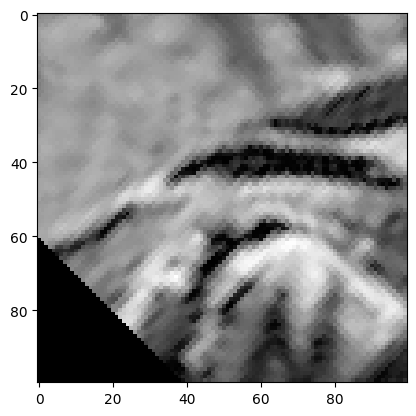

In [381]:
i = 401
print(descriptors[i][0], descriptors[i][1], descriptors[i][2], descriptors[i][3])
plt.imshow(descriptors[i][4], cmap='gray')

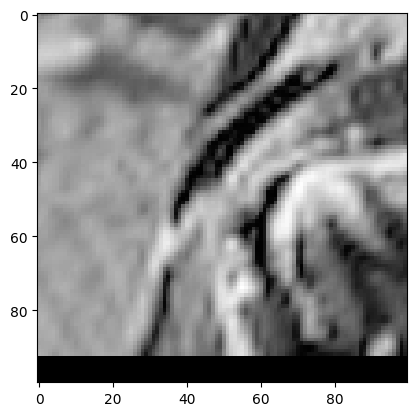

In [382]:
plt.imshow(backward_warping_window(554, 596, low_pyramid[1]['G'], 100, 0), cmap='gray')


In [373]:
print(math.atan2(1, 1))

0.7853981633974483


In [375]:
print(math.pi/ 4)

0.7853981633974483


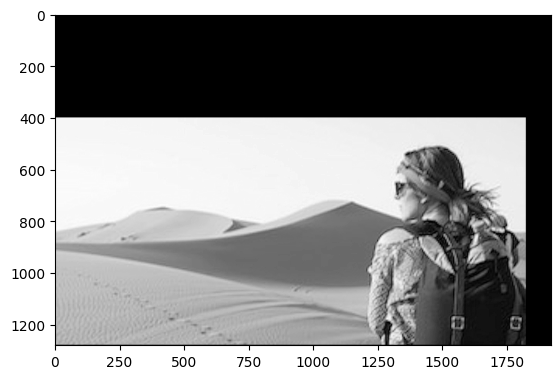

In [231]:
# implementing algorithm for backward warping using bilinear interpolation 
def backward_warping(img, H):
    # Create the inverse transformation matrix
    output_img = np.zeros_like(img)
    # Iterate over the pixels in the output image
    for y in range(output_img.shape[0] -1):
        for x in range(output_img.shape[1] -1):
            # Apply the inverse transformation to the pixel coordinates
            p = np.array([x, y, 1])
            p_prime = np.dot(H, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Check if the transformed pixel is within the bounds of the input image
            if 0 <= p_prime[0] < img.shape[1] and 0 <= p_prime[1] < img.shape[0]:
                # Perform bilinear interpolation
                x0, y0 = int(p_prime[0]), int(p_prime[1])
                x1, y1 = x0 + 1, y0 + 1
                dx, dy = p_prime[0] - x0, p_prime[1] - y0
                # Perform the interpolation
                try:
                    output_img[y, x] = (1 - dx) * (1 - dy) * img[y0, x0] + dx * (1 - dy) * img[y0, x1] + (1 - dx) * dy * img[y1, x0] + dx * dy * img[y1, x1]
                except:
                    pass
    return output_img





# show the result of backward warping
H = np.array([[1, 0, 100], [0, 1, -400], [0, 0, 1]])
warped_img = backward_warping(img_low_res_gray, H)
plt.imshow(warped_img, cmap='gray')

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

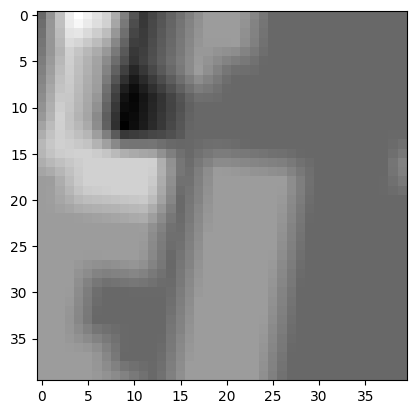

[array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape=(9, 0), dtype=float64),
 array([], shape